Modified from the [original](https://github.com/willyhagi/climate-data-science) (Companion Jupyter Notebook to the [MODIS Vegetation Indices: a GEE Approach](https://towardsdatascience.com/modis-vegetation-indices-a-gee-approach-f48e1259e462) article, published in Towards Data Science) by [spestana](https://github.com/spestana/) 

**Import all the packages we'll be using here**

In [1]:
import ee 
import folium
import geehydro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from ipygee import *

**Initialize the Google Earth Engine library**

In [2]:
# Initialize the library.
ee.Initialize()

**Set our Area of Interest (AOI)**

[Clear Lake National Wildlife Refuge](https://www.fws.gov/refuge/clear_lake/) in California

In [3]:
clearlake_aoi = ee.Geometry.Rectangle([-121.0, 41.95,
                                   -121.3, 41.75])

**Get MODIS Products**

[Full product list on GEE](https://developers.google.com/earth-engine/datasets/catalog/modis)

Here I'm getting:
* MOD11A1 Terra LST
* MOD13Q1 Vegetation Indices

In [15]:
modis_veg = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(ee.DateRange('2016-01-01',
                                                                        '2019-12-01'))

modis_lst = ee.ImageCollection("MODIS/006/MOD11A1").filterDate(ee.DateRange('2016-01-01',
                                                                        '2019-12-01'))

In [6]:
# select EVI and NDVI
evi = modis_veg.select('EVI')
ndvi = modis_veg.select('NDVI')

# select LST
lst_day = modis_lst.select('LST_Day_1km')
lst_night = modis_lst.select('LST_Night_1km')

In [7]:
def scale_factor_NDVI(image):
  # scale factor for the MODIS MOD13Q1 product
  return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

def scale_factor_LST(image):
  # scale factor for the MODIS MOD13Q1 product
  return image.multiply(0.02).copyProperties(image, ['system:time_start'])

In [8]:
# mapping function to multiply by the scale factor
scaled_evi = evi.map(scale_factor_NDVI)
scaled_ndvi = ndvi.map(scale_factor_NDVI)
scaled_lst_day = lst_day.map(scale_factor_LST)
scaled_lst_night = lst_night.map(scale_factor_LST)

Visualize the mean daytime temperature on a map:

In [18]:
Map = folium.Map(location=[41.85, -121.13], zoom_start=10)
Map.setOptions('HYBRID')
Map.addLayer(clearlake_aoi)

Map.addLayer(scaled_lst_day.mean().clip(clearlake_aoi),
             vis_params={'min': 250,
                         'max':300,
                        # 'palette': ['red', 'yellow', 'green']
                        })
Map

**Get the mean day and night LST for this whole *clearlake_aoi*:**

In [10]:
# Daytime LST time series
clearlake_lst_day = chart.Image.series(**{'imageCollection': scaled_lst_day,
                                   'region': clearlake_aoi,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})

# Nighttime LST time series
clearlake_lst_night = chart.Image.series(**{'imageCollection': scaled_lst_night,
                                   'region': clearlake_aoi,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})

**Convert to pandas dataframes:**

In [11]:
clearlake_lst_day_df = clearlake_lst_day.dataframe
clearlake_lst_night_df = clearlake_lst_night.dataframe

**Plot LST timeseries**

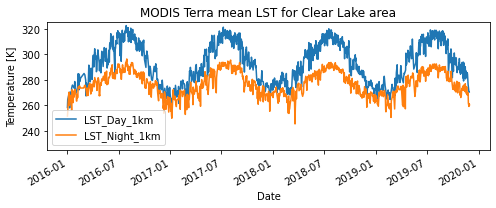

In [24]:
fig, ax = plt.subplots(figsize=(7, 3))

clearlake_lst_day_df.plot(ax=ax)
clearlake_lst_night_df.plot(ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature [K]');
ax.set_title('MODIS Terra mean LST for Clear Lake area')

ax.set_ylim((225,325))

ax.legend(loc='lower left')

plt.tight_layout()
plt.show()

**Plot timeseries aggregated to monthly means**

In [13]:
# monthly averaging
clearlake_lst_day_monthly_df = clearlake_lst_day_df.groupby(pd.Grouper(freq="M")).mean()
clearlake_lst_night_monthly_df = clearlake_lst_night_df.groupby(pd.Grouper(freq="M")).mean()

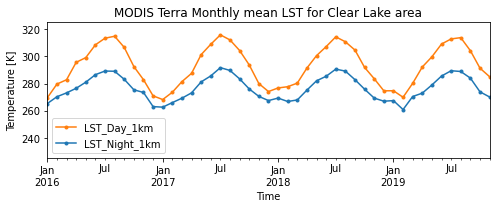

In [34]:
fig, ax = plt.subplots(figsize=(7, 3))

clearlake_lst_day_monthly_df.plot(ax=ax, c='tab:orange', marker='.', linestyle='-')
clearlake_lst_night_monthly_df.plot(ax=ax, c='tab:blue', marker='.', linestyle='-')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature [K]')
ax.set_title('MODIS Terra Monthly mean LST for Clear Lake area')

ax.set_ylim((225,325))

ax.legend(loc='lower left')

plt.tight_layout()
plt.show()